In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import argparse
from matplotlib.patches import ConnectionPatch
import unicodedata
import re

In [73]:
df = pd.read_csv('./response.csv', sep=',', engine="python", encoding='utf-8')

In [74]:
def normalizar(df):
    coluna_pattern="institu"
    colunas = [col for col in df.columns if coluna_pattern.lower() in col.lower()]
    if not colunas:
        raise ValueError(f"Nenhuma coluna encontrada com padrão '{coluna_pattern}' no nome das colunas: {df.columns.tolist()}")
    coluna_alvo = colunas[0]
    mask = (
        df[coluna_alvo].str.contains("IF", case=False, na=False) |
        df[coluna_alvo].str.contains("instituto federal catarinense", case=False, na=False)
    )
    df.loc[mask, coluna_alvo] = 'IFC'
    coluna_pattern="o seu curso "
    colunas = [col for col in df.columns if coluna_pattern.lower() in col.lower()]
    if not colunas:
        raise ValueError(f"Nenhuma coluna encontrada com padrão '{coluna_pattern}' no nome das colunas: {df.columns.tolist()}")
    coluna_alvo = colunas[0]
    mask = (
        df[coluna_alvo].str.contains("BCC", case=False, na=False) |
        df[coluna_alvo].str.contains("Computação", case=False, na=False)
    )
    df.loc[mask, coluna_alvo] = 'BCC'
    mask = (
        df[coluna_alvo].str.contains("Informática", case=False, na=False) |
        df[coluna_alvo].str.contains("técnico", case=False, na=False)
    )
    df.loc[mask, coluna_alvo] = 'Téc Info'
    mask = (
        df[coluna_alvo].str.contains("Software", case=False, na=False) 
    )
    df.loc[mask, coluna_alvo] = 'Eng de Soft'
    mask = (
        df[coluna_alvo].str.contains("informação", case=False, na=False) 
    )
    df.loc[mask, coluna_alvo] = 'Sist de Info'
    mask = (
        df[coluna_alvo].str.contains("web", case=False, na=False) 
    )
    df.loc[mask, coluna_alvo] = 'Dev Web'

    new = ['data', 'email', 'nome', 'instituicao', 'curso', 'trabalho', 'plataforma', 'perifericos', 'importancia', 'genero', 'influcencia', 'aplicacao', 'horas', 'investimento', 'fatores de compra']

    novo_nome_colunas = {col_antigo: col_novo for col_antigo, col_novo in zip(df.columns, new)}
    
    return df.rename(columns=novo_nome_colunas)

In [75]:
df_tratado = normalizar(df)
df_tratado.head()

,data,email,nome,instituicao,curso,trabalho,plataforma,perifericos,importancia,genero,influcencia,aplicacao,horas,investimento,fatores de compra
0,2025/04/22 10:00:51 AM GMT-3,fmachad6@gmail.com,Felipe Caue Machado,IFC,BCC,Sim,PC desktop;Notebook,Mouse e Teclado,3,FPS/TPS (tiro em primeira/terceira pessoa),5,5,4,Até R$ 50,Preço;Especificações Técnicas
1,2025/04/22 10:09:22 AM GMT-3,magdielprestes@gmail.com,Magdiel Prestes Rodrigues,IFC,BCC,Não,Notebook;Dispositivo Móvel (Celular/Tablet),Mouse e Teclado,5,FPS/TPS (tiro em primeira/terceira pessoa);Est...,4,3,4,Até R$ 50,Preço;Review
2,2025/04/22 10:09:59 AM GMT-3,pedroo-phd@outlook.com,Pedro Henrique Damann,IFC,BCC,Não,PC desktop;Notebook;Dispositivo Móvel (Celular...,Mouse e Teclado,3,FPS/TPS (tiro em primeira/terceira pessoa);RPG...,2,3,3,Até R$ 50,Review;Especificações Técnicas
3,2025/04/22 10:13:28 AM GMT-3,rodrigo.voigt.f@gmail.com,Rodrigo Voigt Filho,IFC,Téc Info,Não,Notebook;Dispositivo Móvel (Celular/Tablet);Po...,Mouse e Teclado,4,FPS/TPS (tiro em primeira/terceira pessoa);RPG...,5,4,5,Até R$ 50,Preço;Review
4,2025/04/22 10:14:08 AM GMT-3,gianlucamk04@gmail.com,Gianluca Matos Klaumann,IFC,BCC,Sim,"PC desktop;Notebook;Console (Playstation, Xbox...",Controle,5,FPS/TPS (tiro em primeira/terceira pessoa);RPG...,4,3,15,Até R$ 50,Preço;Review


In [116]:
def plotChart(col, kind, df=df_tratado):
    if kind == 'pie-bar':
        proporcoes = df[col].value_counts(normalize=True)
        labels = proporcoes.index.tolist()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
        fig.subplots_adjust(wspace=0)

        # Pie Chart
        explode = [0.05] * len(labels)
        angle = -180 * proporcoes.iloc[0]
        wedges, *_ = ax1.pie(proporcoes, autopct='%1.1f%%', startangle=angle,
                             labels=labels, explode=explode)

        ax1.set_title(f'Distribuição de {col} - Pizza')

        # Bar Chart
        bottom = 1
        width = .2
        total_categorias = len(proporcoes)

        # Ajuste automático do alpha conforme número de categorias
        alpha_base = 0.3
        alpha_incremento = 0.7 / max(total_categorias - 1, 1)

        for j, (height, label) in enumerate(reversed(list(zip(proporcoes, labels)))):
            bottom -= height
            alpha = min(alpha_base + alpha_incremento * j, 1.0)
            bc = ax2.bar(0, height, width, bottom=bottom, color='C0', alpha=alpha, label=label)
            ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

        ax2.set_title(f'Distribuição de {col} - Barras')
        ax2.legend()
        ax2.axis('off')
        ax2.set_xlim(-2.5 * width, 2.5 * width)

        # Conectar Pie -> Bar
        theta1, theta2 = wedges[0].theta1, wedges[0].theta2
        center, r = wedges[0].center, wedges[0].r
        bar_height = sum(proporcoes)

        # Linha superior
        x = r * np.cos(np.pi / 180 * theta2) + center[0]
        y = r * np.sin(np.pi / 180 * theta2) + center[1]
        con = ConnectionPatch(xyA=(-width/2, bar_height), coordsA=ax2.transData,
                              xyB=(x, y), coordsB=ax1.transData, color='black', linewidth=2)
        ax2.add_artist(con)

        # Linha inferior
        x = r * np.cos(np.pi / 180 * theta1) + center[0]
        y = r * np.sin(np.pi / 180 * theta1) + center[1]
        con = ConnectionPatch(xyA=(-width/2, 0), coordsA=ax2.transData,
                              xyB=(x, y), coordsB=ax1.transData, color='black', linewidth=2)
        ax2.add_artist(con)
    elif kind == 'bartwo':
        plt.figure()
        df[col].value_counts(normalize=True).plot(kind='barh')
        plt.title(f'Distribuição de {col}')
        plt.xlabel(col)
        plt.ylabel('Contagem')
    elif kind == 'pie':
        counts = df[col].value_counts()
        plt.figure(figsize=(10, 6))
        total = counts.sum()
        counts.plot(
            kind='pie',
            autopct=lambda pct: f"{int(pct * total / 100)} ({pct:.2f}%)",
            pctdistance=0.7,                # distância do % ao centro
            labeldistance=1.1,              # distância das labels (índice)
            startangle=90,                  # rotação inicial
            wedgeprops=dict(width=0.4)      # largura do anel (para donut)
        )
        plt.ylabel('') 
        plt.title(f'Distribuição de {col}')
        if kind != 'pie':
            plt.xlabel(col)
            plt.ylabel('Contagem')
        plt.tight_layout()
    else:
        plt.figure()
        df[col].plot(kind=kind)
        plt.title(f'Distribuição de {col}')
        plt.xlabel(col)
        plt.ylabel('Contagem')
    plt.show()

In [107]:
def separar_registros(df, coluna, separador=';'):
    df[coluna] = df[coluna].str.split(separador)
    return df.explode(coluna).reset_index(drop=True)

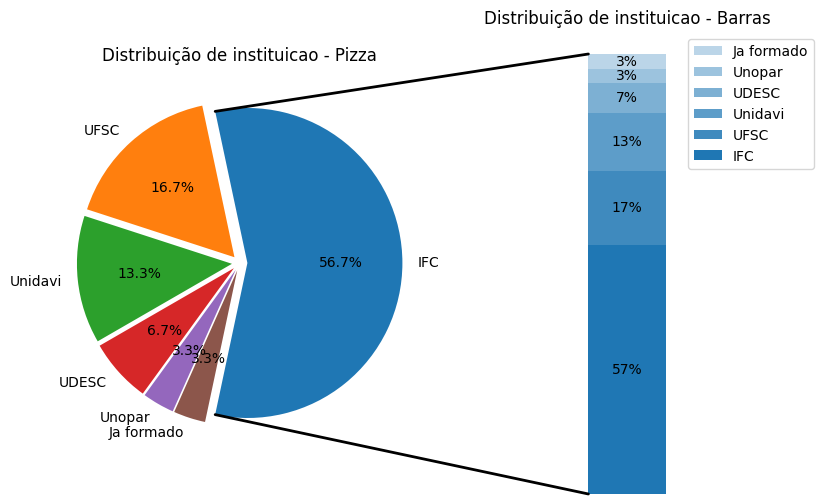

In [77]:
plotChart('instituicao', 'pie-bar', df_tratado)

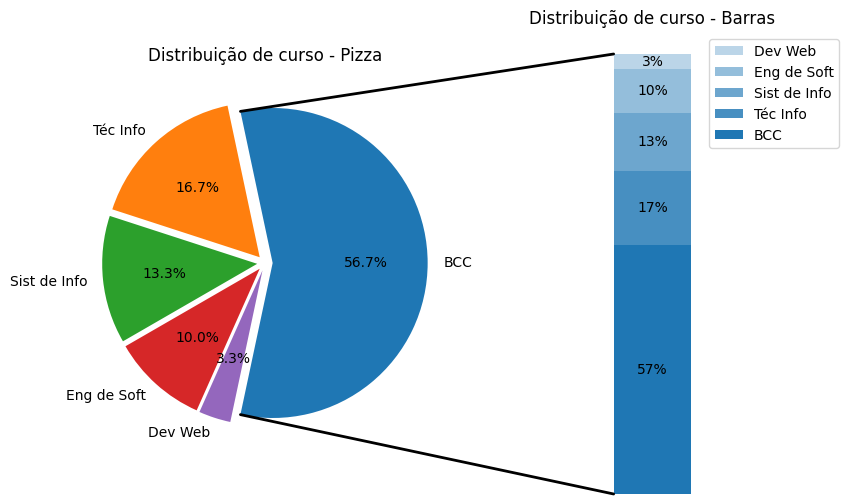

In [88]:
plotChart('curso', 'pie-bar', df_tratado)

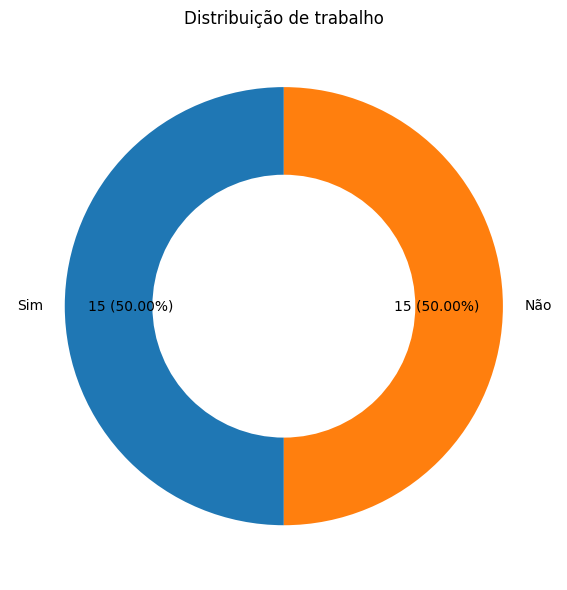

In [89]:
plotChart('trabalho', 'pie', df_tratado)

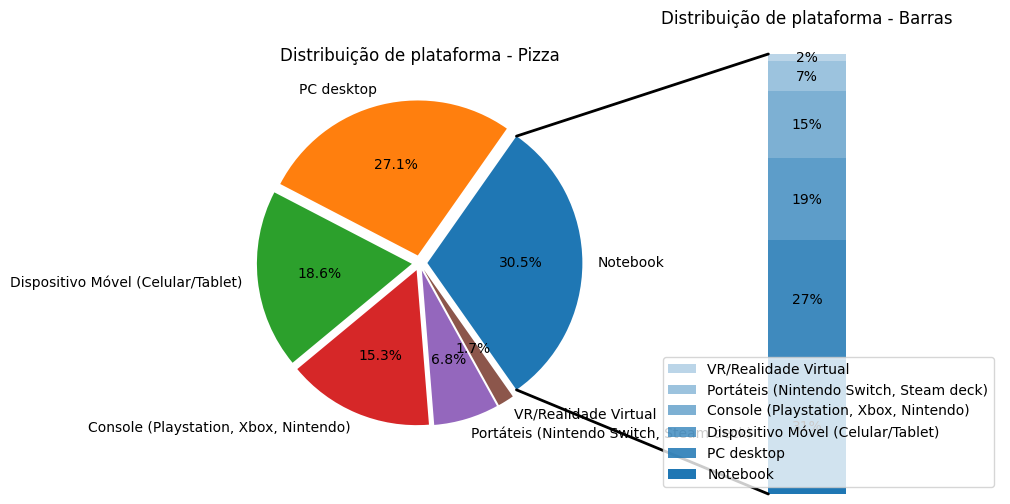

In [108]:
df_separado = separar_registros(df_tratado.copy(), 'plataforma')
plotChart('plataforma', 'pie-bar', df_separado)

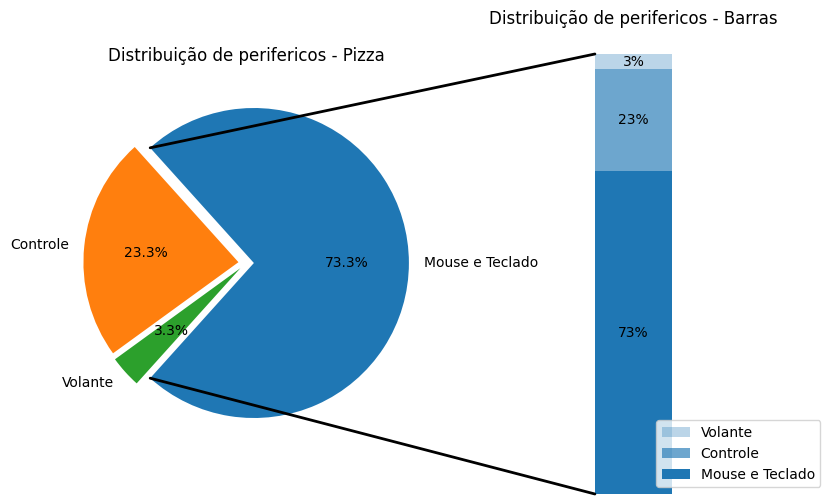

In [90]:
plotChart('perifericos', 'pie-bar', df_tratado)

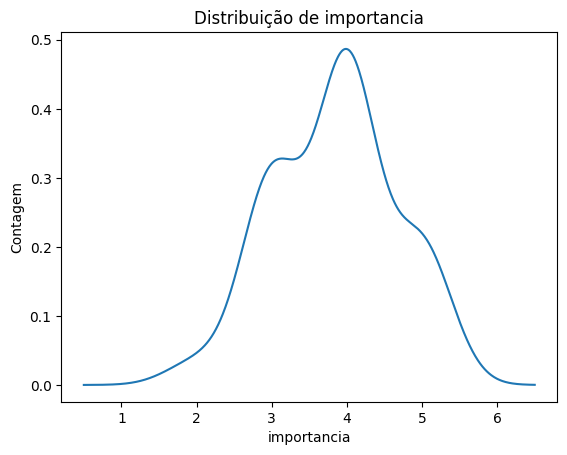

In [91]:
plotChart('importancia', 'kde', df_tratado)

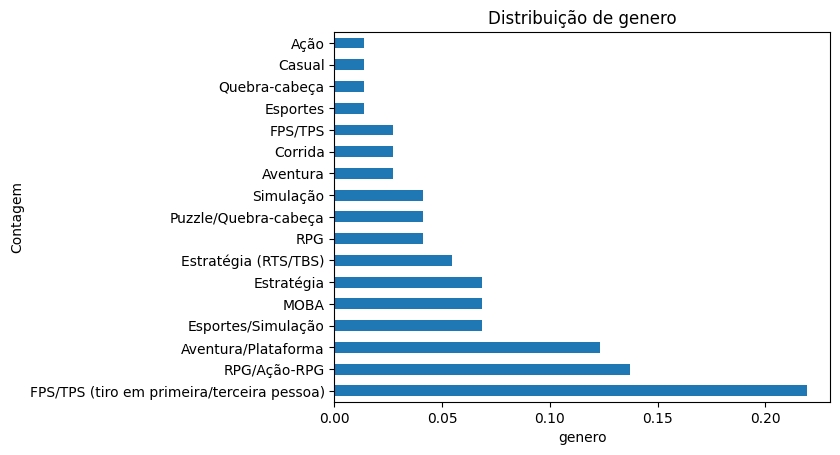

In [117]:
df_separado = separar_registros(df_tratado.copy(), 'genero')
plotChart('genero', 'bartwo', df_separado)

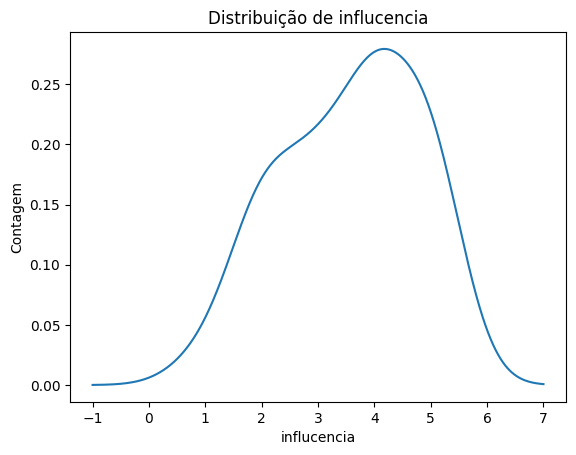

In [92]:
plotChart('influcencia', 'kde', df_tratado)

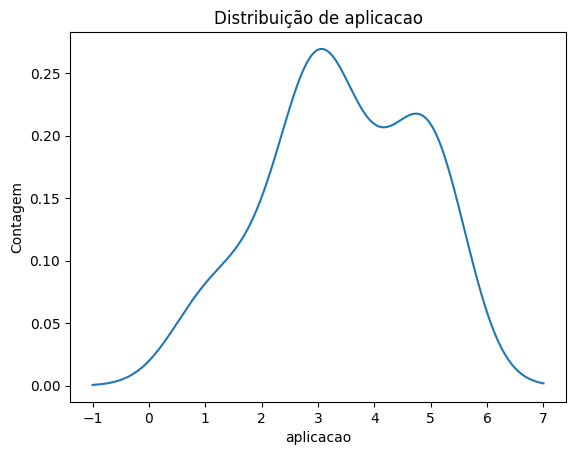

In [93]:
plotChart('aplicacao', 'kde', df_tratado)

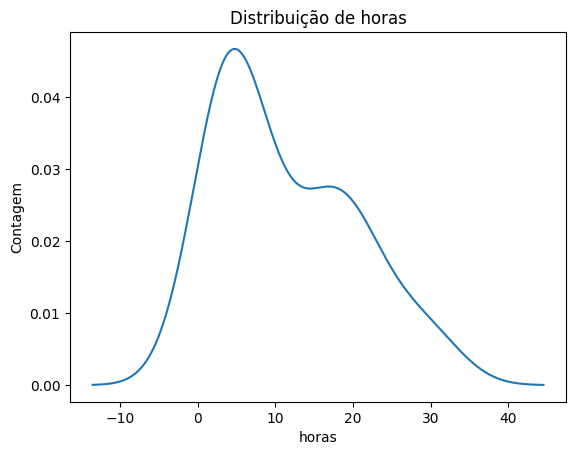

In [94]:
plotChart('horas', 'density', df_tratado)

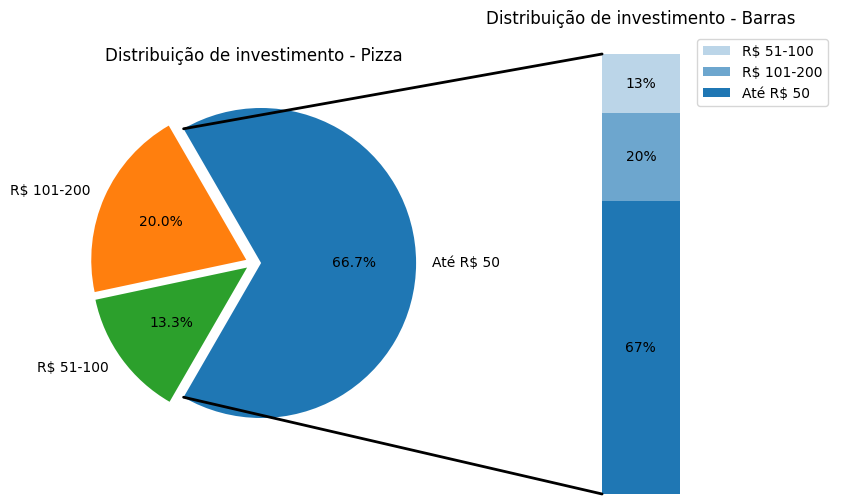

In [95]:
plotChart('investimento', 'pie-bar', df_tratado)

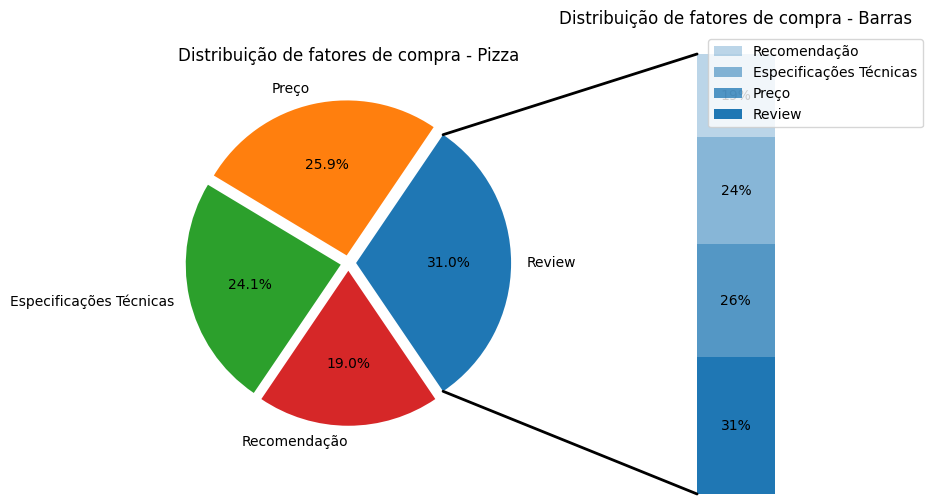

In [119]:
df_separado = separar_registros(df_tratado.copy(), 'fatores de compra')
plotChart('fatores de compra', 'pie-bar', df_separado)